In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# # Fungsi untuk membuat struktur folder dan membagi data
# def split_data(source_dir, base_dir, train_size=0.8, val_size=0.1, test_size=0.1):
#     # Membuat folder utama untuk train, val, dan test
#     os.makedirs(base_dir, exist_ok=True)
#     train_dir = os.path.join(base_dir, 'train')
#     val_dir = os.path.join(base_dir, 'val')
#     test_dir = os.path.join(base_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     # Menentukan kategori (misalnya acne, non-acne)
#     categories = os.listdir(source_dir)

#     # Untuk setiap kategori, buat folder di train, val, test dan pindahkan gambar
#     for category in categories:
#         category_dir = os.path.join(source_dir, category)
#         files = os.listdir(category_dir)
#         random.shuffle(files)

#         # Menghitung jumlah data untuk training, validation, dan testing
#         total_files = len(files)
#         train_count = int(train_size * total_files)
#         val_count = int(val_size * total_files)
#         test_count = total_files - train_count - val_count  # Sisanya untuk test

#         # Buat folder untuk kategori di setiap subset
#         os.makedirs(os.path.join(train_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, category), exist_ok=True)

#         # Pindahkan file ke folder masing-masing
#         for i, file in enumerate(files):
#             source_file = os.path.join(category_dir, file)

#             if i < train_count:
#                 target_dir = os.path.join(train_dir, category)
#             elif i < train_count + val_count:
#                 target_dir = os.path.join(val_dir, category)
#             else:
#                 target_dir = os.path.join(test_dir, category)

#             shutil.copy(source_file, target_dir)

# # Tentukan direktori sumber dan tujuan
# source_dir = '/content/drive/MyDrive/BEAUSKIN ML/ACNE_DATASET'
# base_dir = '/content/drive/MyDrive/BEAUSKIN ML/ACNE_DETECTION'

# # Panggil fungsi untuk membagi dataset
# split_data(source_dir, base_dir)


In [5]:
train_dir = '/content/drive/MyDrive/ACNE_DETECTION/train'
val_dir = '/content/drive/MyDrive/ACNE_DETECTION/val'
test_dir = '/content/drive/MyDrive/ACNE_DETECTION/test'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    class_mode='binary'
)


Found 2543 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Found 319 images belonging to 2 classes.


In [7]:
# Mendapatkan label dari train_generator
class_labels = train_generator.class_indices
print("Class Labels:", class_labels)

Class Labels: {'No': 0, 'Yes': 1}


In [8]:
# Load MobileNetV2 dengan pretrained weights dari ImageNet, tanpa lapisan top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
base_model.trainable = False

In [10]:
# Memulai dengan input base model
x = base_model.output

# Tambahkan lapisan pooling global
x = GlobalAveragePooling2D()(x)

# Tambahkan lapisan Dense untuk klasifikasi
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # 3 output neurons untuk 3 kelas kulit

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=x)

In [11]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [12]:
# Training model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose = 1,
                    )

Epoch 1/20
80/80 [==============================] - 360s 4s/step - loss: 0.0962 - accuracy: 0.9615 - val_loss: 0.0417 - val_accuracy: 0.9905
Epoch 2/20
80/80 [==============================] - 28s 350ms/step - loss: 0.0438 - accuracy: 0.9827 - val_loss: 0.0826 - val_accuracy: 0.9685
Epoch 3/20
80/80 [==============================] - 28s 347ms/step - loss: 0.0463 - accuracy: 0.9827 - val_loss: 0.0298 - val_accuracy: 0.9874
Epoch 4/20
80/80 [==============================] - 28s 349ms/step - loss: 0.0448 - accuracy: 0.9843 - val_loss: 0.0293 - val_accuracy: 0.9905
Epoch 5/20
80/80 [==============================] - 28s 350ms/step - loss: 0.0256 - accuracy: 0.9894 - val_loss: 0.0360 - val_accuracy: 0.9874
Epoch 6/20
80/80 [==============================] - 28s 347ms/step - loss: 0.0244 - accuracy: 0.9906 - val_loss: 0.0252 - val_accuracy: 0.9968
Epoch 7/20
80/80 [==============================] - 28s 349ms/step - loss: 0.0223 - accuracy: 0.9913 - val_loss: 0.0254 - val_accuracy: 0.9905
E

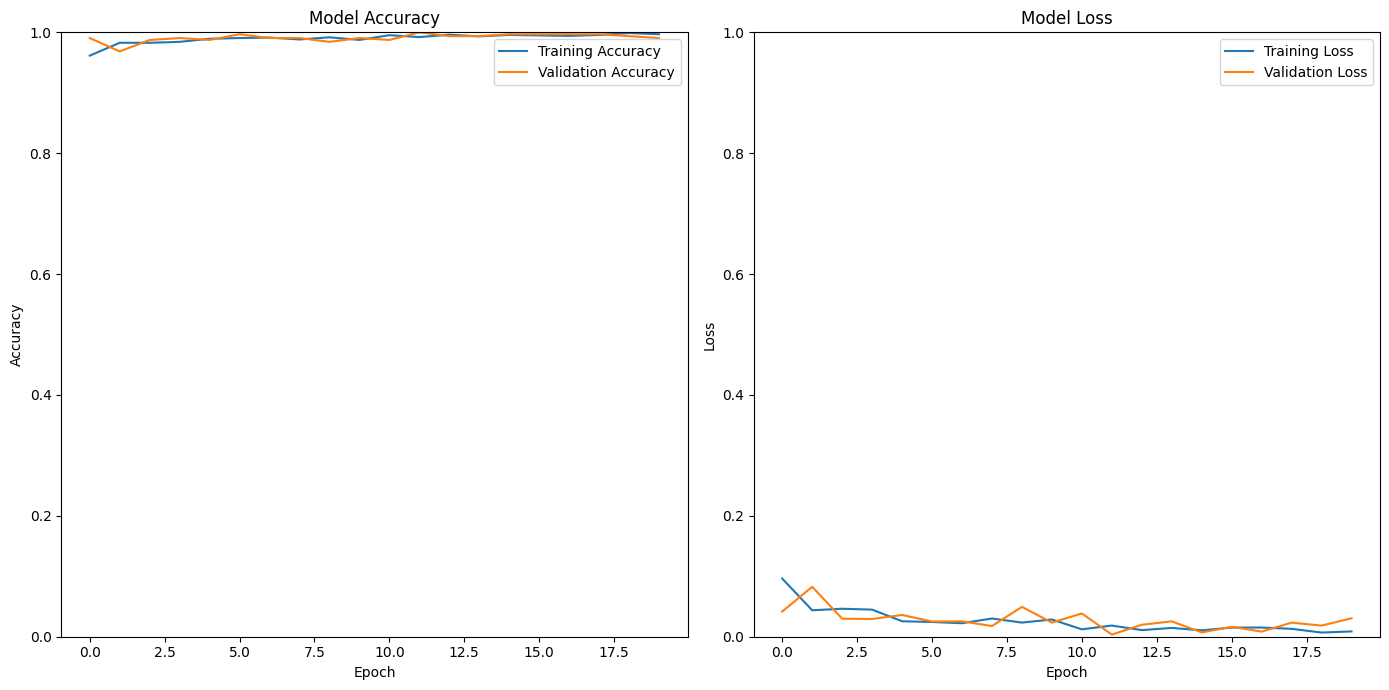

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(14, 7))  # Increase figure size for better clarity

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


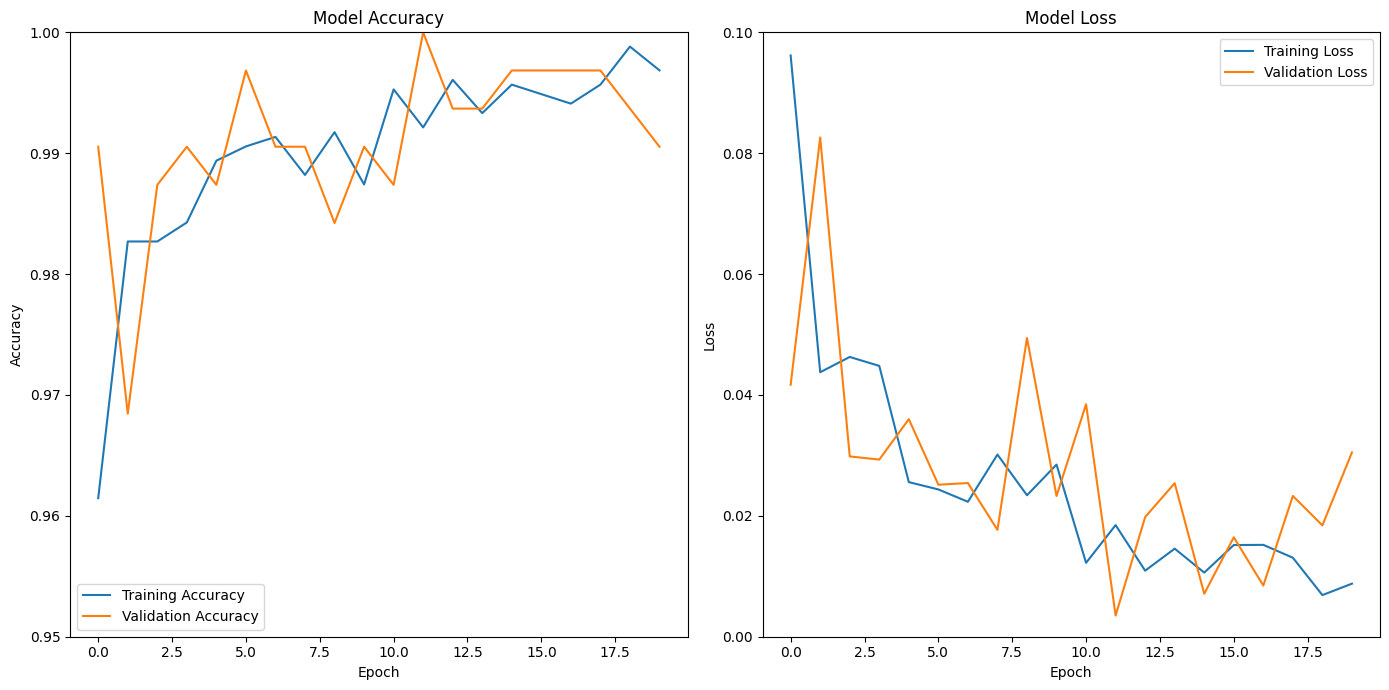

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(14, 7))  # Increase figure size for better clarity

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.95, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0, 0.1])

plt.tight_layout()
plt.show()


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 67s 8s/step - loss: 0.0516 - accuracy: 0.9861
Test Loss: 0.05161554738879204
Test Accuracy: 0.9861111044883728


In [25]:
model.save('/content/drive/MyDrive/Colab Notebooks/acne_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


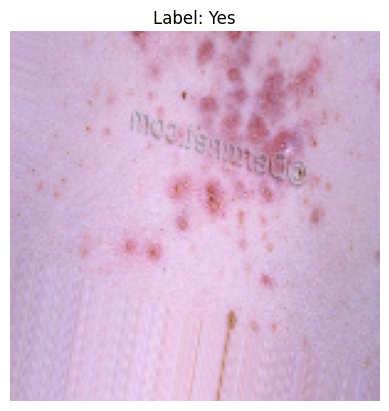

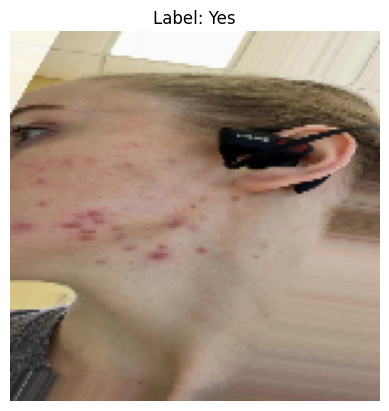

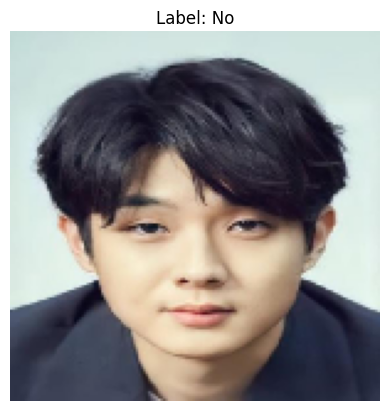

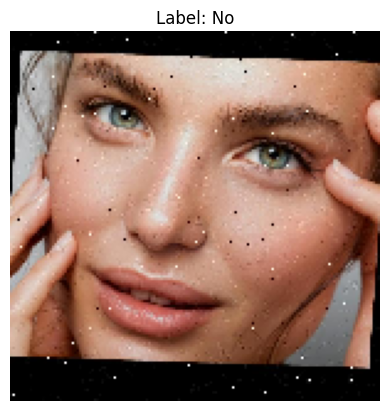

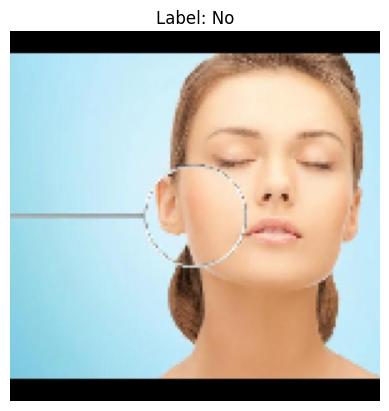

In [26]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(150, 150))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(5):
    load_and_display_random_image_with_label()
